In [104]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import xgboost as xgb
import pandas_datareader.data as web
import datetime
import yfinance as yf
from prophet import Prophet

In [105]:
# Gold price api
gold = yf.download('GC=F', start='2000-01-01', end='2026-02-20', multi_level_index=False, progress = False, auto_adjust=True)['Close']
gold.to_csv('gold_price_daily.csv')
gold = gold.to_frame()
gold.index = pd.to_datetime(gold.index)

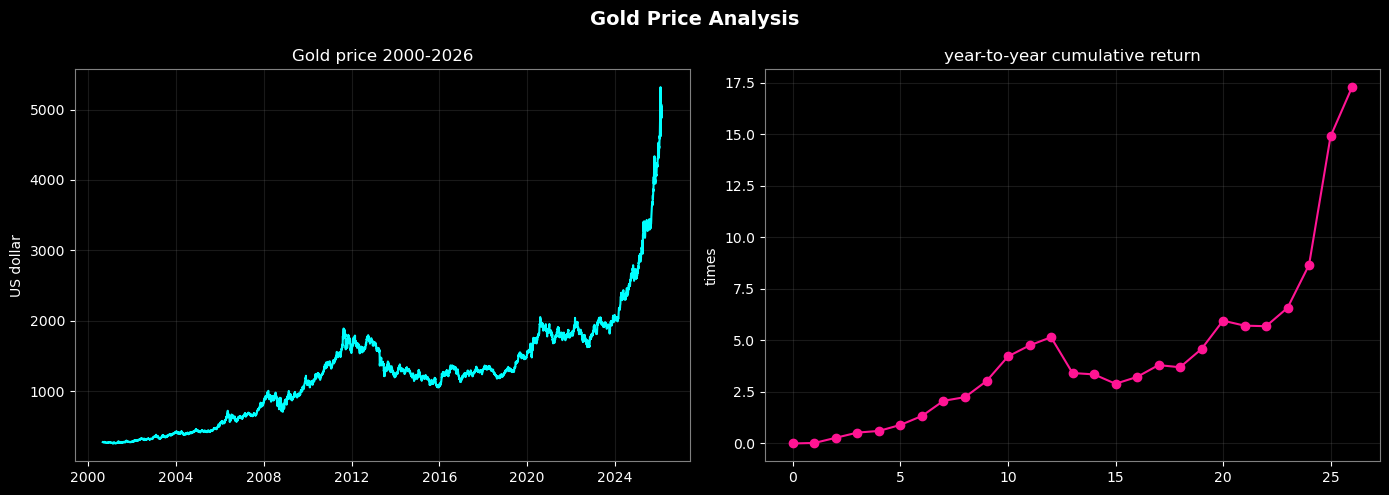

In [106]:
# Gold price plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('black')
fig.suptitle('Gold Price Analysis', color='white', fontsize=14, fontweight='bold')

# left graph - Gold price
ax1 = axes[0]
ax1.plot(gold.index, gold['Close'], color='cyan', linewidth=1.5)
ax1.set_title('Gold price 2000-2026', color='white')
ax1.set_ylabel('US dollar', color='white')
ax1.set_facecolor('black')
ax1.grid(True, alpha=0.2, color='gray')
ax1.tick_params(colors='white')

# Add year-to-year cumulative return
df_year = gold.groupby(gold.index.strftime('%Y')).tail(1).reset_index(drop=True) # Record the last day of each year
df_year['Cumulative_Return'] = (df_year['Close'] - df_year.iloc[0]['Close']) / df_year.iloc[0]['Close']

ax2 = axes[1]
ax2.plot(df_year.index, df_year['Cumulative_Return'], color='deeppink', linewidth=1.5, marker='o', markersize=6)
ax2.set_title('year-to-year cumulative return', color='white')
ax2.set_ylabel('times', color='white')
ax2.set_facecolor('black')
ax2.grid(True, alpha=0.2, color='gray')
ax2.tick_params(colors='white')

# Style the spine
for ax in axes:
    for spine in ax.spines.values():
        spine.set_color('gray')
    for label in ax.get_xticklabels():
        label.set_color('white')
    for label in ax.get_yticklabels():
        label.set_color('white')

plt.tight_layout()
plt.show()

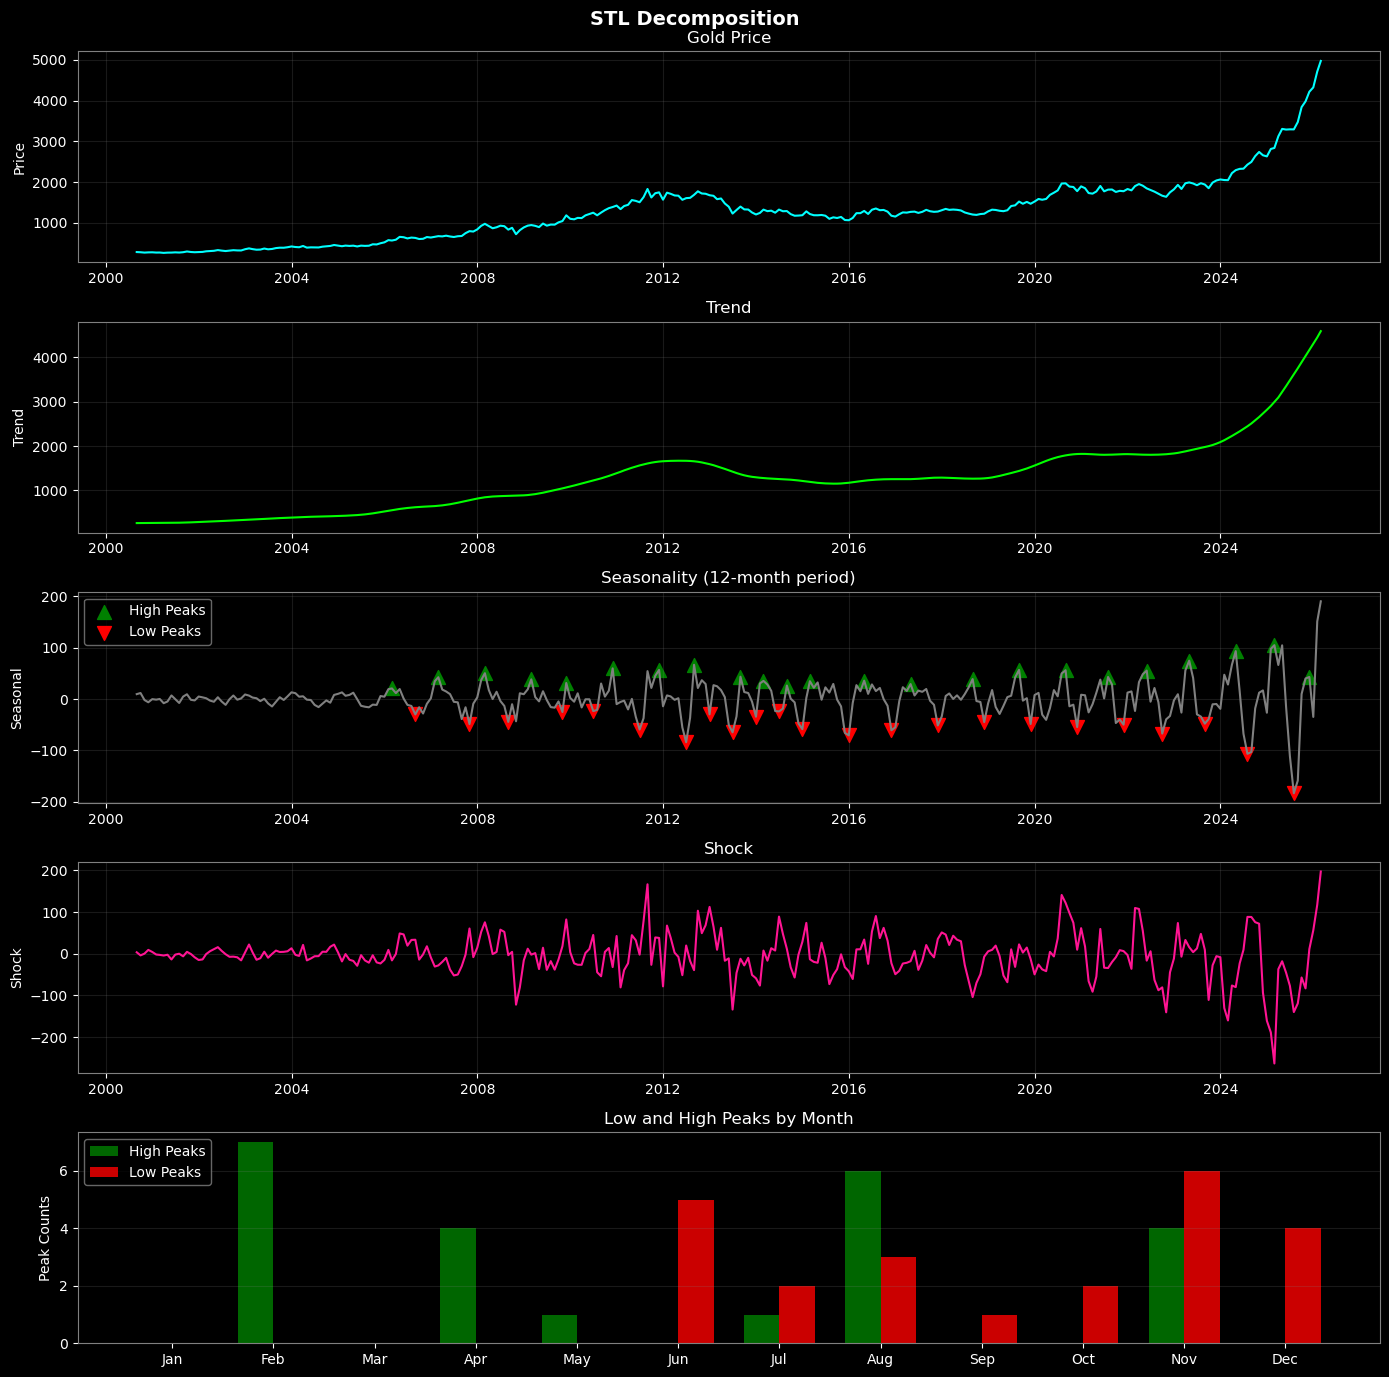

In [107]:
# STL decomposition and peak detection

df_month = gold.resample('ME').last().reset_index()  # Resample to monthly frequency using the last day of each month
ts = df_month.set_index('Date')['Close']
stl = STL(ts, period=12)
result = stl.fit()

trend = result.trend
seasonality = result.seasonal
shock = result.resid

# Find peaks in seasonality

# prominence → how much the peak stands out from surroundings
# distance → minimum spacing between peaks

std = seasonality.std()

MIN_PROMINENCE = std * 1.0
MIN_DISTANCE = 6             # minimum ~6 months between peaks

# High peaks
high_peaks, high_props = find_peaks(
    seasonality,
    prominence=MIN_PROMINENCE,
    distance=MIN_DISTANCE
)

# Low peaks
low_peaks, low_props = find_peaks(
    -seasonality,
    prominence=MIN_PROMINENCE,
    distance=MIN_DISTANCE
)

# Extract peak months
seasonality_index = seasonality.index
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
high_peak_months = pd.to_datetime(seasonality_index[high_peaks]).month
low_peak_months = pd.to_datetime(seasonality_index[low_peaks]).month

# Count peaks per month

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

high_peak_counts = (
    pd.Series(high_peak_months)
    .map(month_dict)
    .value_counts()
    .reindex(month_order, fill_value=0)
)

low_peak_counts = (
    pd.Series(low_peak_months)
    .map(month_dict)
    .value_counts()
    .reindex(month_order, fill_value=0)
)

# Create matplotlib subplots
fig, axes = plt.subplots(5, 1, figsize=(14, 14))
fig.patch.set_facecolor('black')
fig.suptitle('STL Decomposition', color='white', fontsize=14, fontweight='bold')

subtitles = ['Gold Price', 'Trend', 'Seasonality (12-month period)', 'Shock', 'Low and High Peaks by Month']

# Price
axes[0].plot(ts.index, ts, color='cyan', linewidth=1.5)
axes[0].set_title(subtitles[0], color='white')
axes[0].set_ylabel('Price', color='white')
axes[0].set_facecolor('black')
axes[0].grid(True, alpha=0.2, color='gray')

# Trend
axes[1].plot(ts.index, trend, color='lime', linewidth=1.5)
axes[1].set_title(subtitles[1], color='white')
axes[1].set_ylabel('Trend', color='white')
axes[1].set_facecolor('black')
axes[1].grid(True, alpha=0.2, color='gray')

# Seasonality
axes[2].plot(ts.index, seasonality, color='gray', linewidth=1.5)
axes[2].scatter(seasonality_index[high_peaks], seasonality.iloc[high_peaks], color='green', s=100, marker='^', label='High Peaks')
axes[2].scatter(seasonality_index[low_peaks], seasonality.iloc[low_peaks], color='red', s=100, marker='v', label='Low Peaks')
axes[2].set_title(subtitles[2], color='white')
axes[2].set_ylabel('Seasonal', color='white')
axes[2].set_facecolor('black')
axes[2].grid(True, alpha=0.2, color='gray')
axes[2].legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# Shock
axes[3].plot(ts.index, shock, color='deeppink', linewidth=1.5)
axes[3].set_title(subtitles[3], color='white')
axes[3].set_ylabel('Shock', color='white')
axes[3].set_facecolor('black')
axes[3].grid(True, alpha=0.2, color='gray')

# Monthly low-high peak counts bar chart
ax5 = axes[4]
x_pos = np.arange(len(high_peak_counts))
width = 0.35
ax5.bar(x_pos - width/2, high_peak_counts.values, width, label='High Peaks', color='green', alpha=0.8)
ax5.bar(x_pos + width/2, low_peak_counts.values, width, label='Low Peaks', color='red', alpha=0.8)
ax5.set_title(subtitles[4], color='white')
ax5.set_ylabel('Peak Counts', color='white')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(high_peak_counts.index)
ax5.set_facecolor('black')
ax5.grid(True, alpha=0.2, color='gray', axis='y')
ax5.legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# Style all axes
for ax in axes:
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('gray')
    for label in ax.get_xticklabels():
        label.set_color('white')
    for label in ax.get_yticklabels():
        label.set_color('white')

plt.tight_layout()
plt.show()

### XGBOOST

In [108]:
# Predict 180 days ahead return
df_xg = gold.copy()

In [109]:
# Fetch external macro indicators from Yahoo Finance and FRED

yh_tickers = ['^GSPC', '^VIX', 'DX-Y.NYB']
yf_data = yf.download(yh_tickers, start="2000-01-01", end="2026-02-20", progress=False, multi_level_index=False, auto_adjust=True)['Close']
yf_data.to_csv('macro_indicators_yf.csv')
name_map = {
    'DX-Y.NYB': 'dollar',
    '^GSPC': 'sp500',
    '^VIX': 'vix'
}
yf_data = yf_data.rename(columns=name_map)

fred_tickers = ['DGS10', 'CPIAUCSL', 'DCOILWTICO']
fred_df = web.DataReader(fred_tickers, 'fred', datetime.datetime(2000, 1, 1), datetime.datetime(2026, 2, 20))
fred_df['CPIAUCSL'] = fred_df['CPIAUCSL'].ffill()
fred_df.to_csv('macro_indicators_fred.csv')

df_xg = df_xg.merge(yf_data, left_index=True, right_index=True, how='left')
df_xg = df_xg.merge(fred_df, left_index=True, right_index=True, how='left')


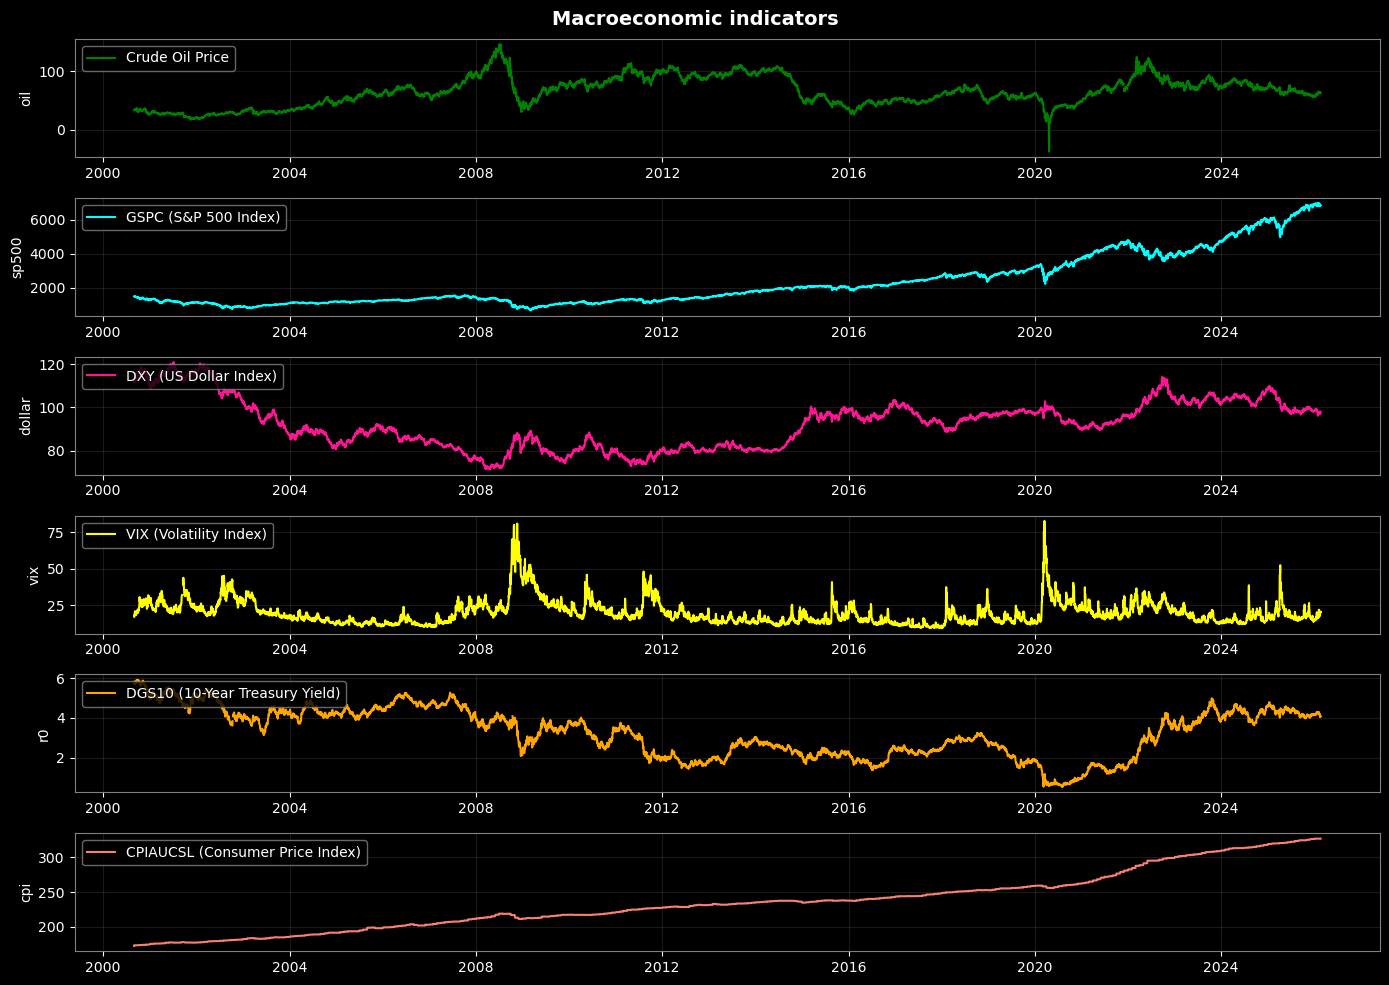

In [110]:
# Plot macro indicators
fig, axes = plt.subplots(6, 1, figsize=(14, 10))
fig.patch.set_facecolor('black')
fig.suptitle('Macroeconomic indicators', color='white', fontsize=14, fontweight='bold')

# crude oil
axes[0].plot(df_xg.index, df_xg['DCOILWTICO'], color='green', linewidth=1.5, label='Crude Oil Price')
axes[0].set_ylabel('oil', color='white')
axes[0].set_facecolor('black')
axes[0].grid(True, alpha=0.2, color='gray')
axes[0].legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# stock market
axes[1].plot(df_xg.index, df_xg['sp500'], color='cyan', linewidth=1.5, label='GSPC (S&P 500 Index)')
axes[1].set_ylabel('sp500', color='white')
axes[1].set_facecolor('black')
axes[1].grid(True, alpha=0.2, color='gray')
axes[1].legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# dollar
axes[2].plot(df_xg.index, df_xg['dollar'], color='deeppink', linewidth=1.5, label='DXY (US Dollar Index)')
axes[2].set_ylabel('dollar', color='white')
axes[2].set_facecolor('black')
axes[2].grid(True, alpha=0.2, color='gray')
axes[2].legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# volatility
axes[3].plot(df_xg.index, df_xg['vix'], color='yellow', linewidth=1.5, label='VIX (Volatility Index)')
axes[3].set_ylabel('vix', color='white')
axes[3].set_facecolor('black')
axes[3].grid(True, alpha=0.2, color='gray')
axes[3].legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# interest rate
axes[4].plot(df_xg.index, df_xg['DGS10'], color='orange', linewidth=1.5, label='DGS10 (10-Year Treasury Yield)')
axes[4].set_ylabel('r0', color='white')
axes[4].set_facecolor('black')
axes[4].grid(True, alpha=0.2, color='gray')
axes[4].legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# consumer price index
axes[5].plot(df_xg.index, df_xg['CPIAUCSL'], color='salmon', linewidth=1.5, label='CPIAUCSL (Consumer Price Index)')
axes[5].set_ylabel('cpi', color='white')
axes[5].set_facecolor('black')
axes[5].grid(True, alpha=0.2, color='gray')
axes[5].legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# Style all axes
for ax in axes:
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('gray')
    for label in ax.get_xticklabels():
        label.set_color('white')
    for label in ax.get_yticklabels():
        label.set_color('white')

plt.tight_layout()
plt.show()

In [111]:
# Feature engineer

#LAG FEATURES
lags = [1,2,3,5,10,20,50,100,180,365]

for lag in lags:
    df_xg[f'lag_close_{lag}'] = df_xg['Close'].shift(lag)
    df_xg[f'lag_return_{lag}'] = df_xg['Close'].shift(lag) / df_xg['Close'].shift(lag+1) - 1

# MOVING AVERAGES FEATURES
windows = [7,30,90,180,365]

for w in windows:
    df_xg[f'MA_{w}'] = df_xg['Close'].shift(1).rolling(w).mean()
    df_xg[f'EMA_{w}'] = df_xg['Close'].shift(1).ewm(span=w).mean()

# TREND FEATURES
df_xg['trend_7_30'] = df_xg['MA_7'] - df_xg['MA_30']
df_xg['trend_30_365'] = df_xg['MA_30'] - df_xg['MA_365']
df_xg['price_vs_MA30'] = df_xg['Close'].shift(1) / df_xg['MA_30'] - 1
df_xg['price_vs_MA365'] = df_xg['Close'].shift(1) / df_xg['MA_365'] - 1

# MOMENTUM FEATURES
df_xg['momentum_7'] = df_xg['Close'].shift(1) / df_xg['Close'].shift(7) - 1
df_xg['momentum_30'] = df_xg['Close'].shift(1) / df_xg['Close'].shift(30) - 1
df_xg['momentum_90'] = df_xg['Close'].shift(1) / df_xg['Close'].shift(90) - 1
df_xg['momentum_180'] = df_xg['Close'].shift(1) / df_xg['Close'].shift(180) - 1
df_xg['momentum_365'] = df_xg['Close'].shift(1) / df_xg['Close'].shift(365) - 1

# VOLATILITY FEATURES
df_xg['return_1'] = df_xg['Close'].pct_change().shift(1)
df_xg['volatility_7'] = df_xg['return_1'].rolling(7).std()
df_xg['volatility_30'] = df_xg['return_1'].rolling(30).std()
df_xg['volatility_90'] = df_xg['return_1'].rolling(90).std()
df_xg['volatility_180'] = df_xg['return_1'].rolling(180).std()

# RSI: Relative Strength Index
delta = df_xg['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
rs = avg_gain / avg_loss
df_xg['rsi_raw'] = 100 - (100 / (1 + rs))
df_xg['rsi_signal'] = df_xg['rsi_raw'].shift(1)

# MACD
exp12 = df_xg['Close'].ewm(span=12, adjust=False).mean()
exp26 = df_xg['Close'].ewm(span=26, adjust=False).mean()
df_xg['macd_raw'] = exp12 - exp26
df_xg['macd_signal'] = df_xg['macd_raw'].shift(1)

df_xg = df_xg.dropna()


In [112]:
# Forecast 1, 30, and 180 days ahead

df_xg['target_180'] = df_xg['Close'].shift(-180) / df_xg['Close'] - 1 
df_xg['target_30'] = df_xg['Close'].shift(-30) / df_xg['Close'] - 1 
df_xg['target_1'] = df_xg['Close'].shift(-1) / df_xg['Close'] - 1 

In [113]:
# Split data

X = df_xg.drop(columns=['target_180', 'target_30', 'target_1', 'rsi_raw', 'macd_raw'])
X_train = X.loc[X.index < '2021-01-31']
X_val = X.loc[(X.index >= '2021-01-31') & (X.index < '2022-02-28')]
X_test = X.loc[X.index >= '2022-02-28']

y_180 = df_xg['target_180']
y_train_180 = y_180.loc[y_180.index < '2021-01-31']
y_val_180 = y_180.loc[(y_180.index >= '2021-01-31') & (y_180.index < '2022-02-28')]
y_test_180 = y_180.loc[y_180.index >= '2022-02-28']

y_30 = df_xg['target_30']
y_train_30 = y_30.loc[y_30.index < '2021-01-31']
y_val_30 = y_30.loc[(y_30.index >= '2021-01-31') & (y_30.index < '2022-02-28')]
y_test_30 = y_30.loc[y_30.index >= '2022-02-28']

y_1 = df_xg['target_1']
y_train_1 = y_1.loc[y_1.index < '2021-01-31']
y_val_1 = y_1.loc[(y_1.index >= '2021-01-31') & (y_1.index < '2022-02-28')]
y_test_1 = y_1.loc[y_1.index >= '2022-02-28']


In [114]:
# Train and fit XGBoost 180-day Model

reg_180 = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=100
)

reg_180.fit(
    X_train,
    y_train_180,
    eval_set=[(X_val, y_val_180)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


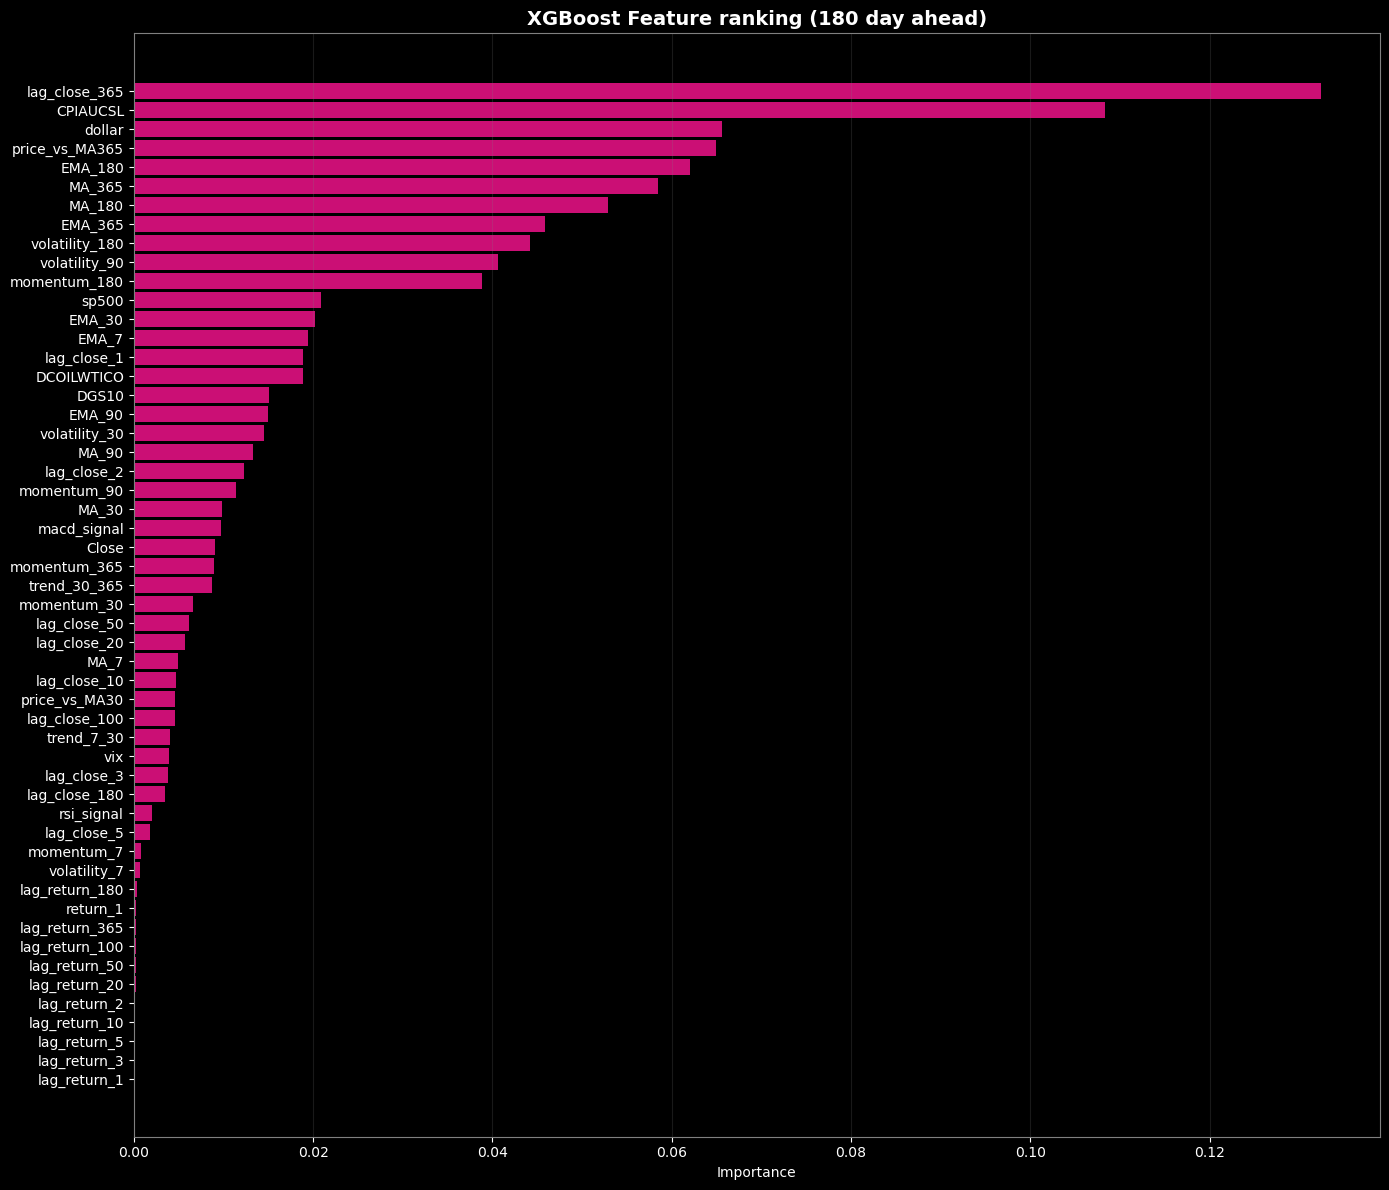

In [115]:
# Ranking feature importance

xg_importance = pd.DataFrame(data = reg_180.feature_importances_, index = reg_180.feature_names_in_, columns = ['Importance']).sort_values(by='Importance', ascending=True)

# Create matplotlib plot
fig, ax = plt.subplots(figsize=(14, 12))
fig.patch.set_facecolor('black')
ax.barh(xg_importance.index, xg_importance['Importance'], color='deeppink', alpha=0.8)
ax.set_title('XGBoost Feature ranking (180 day ahead)', color='white', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance', color='white')
ax.set_facecolor('black')
ax.grid(True, alpha=0.2, color='gray', axis='x')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

In [116]:
# Build confidence interval

val_pred = reg_180.predict(X_val)
residuals = y_val_180 - val_pred
residual_std = residuals.std()
ci_multiplier = 1.96  # 95% confidence interval
print("Residual std:", residual_std)

Residual std: 0.06891687215994123


Model Return RMSE: 0.20651639409089562
Naive RMSE: 632.9350972835655
Model RMSE: 546.2933319397196
Direction_accuracy: 0.9071782178217822


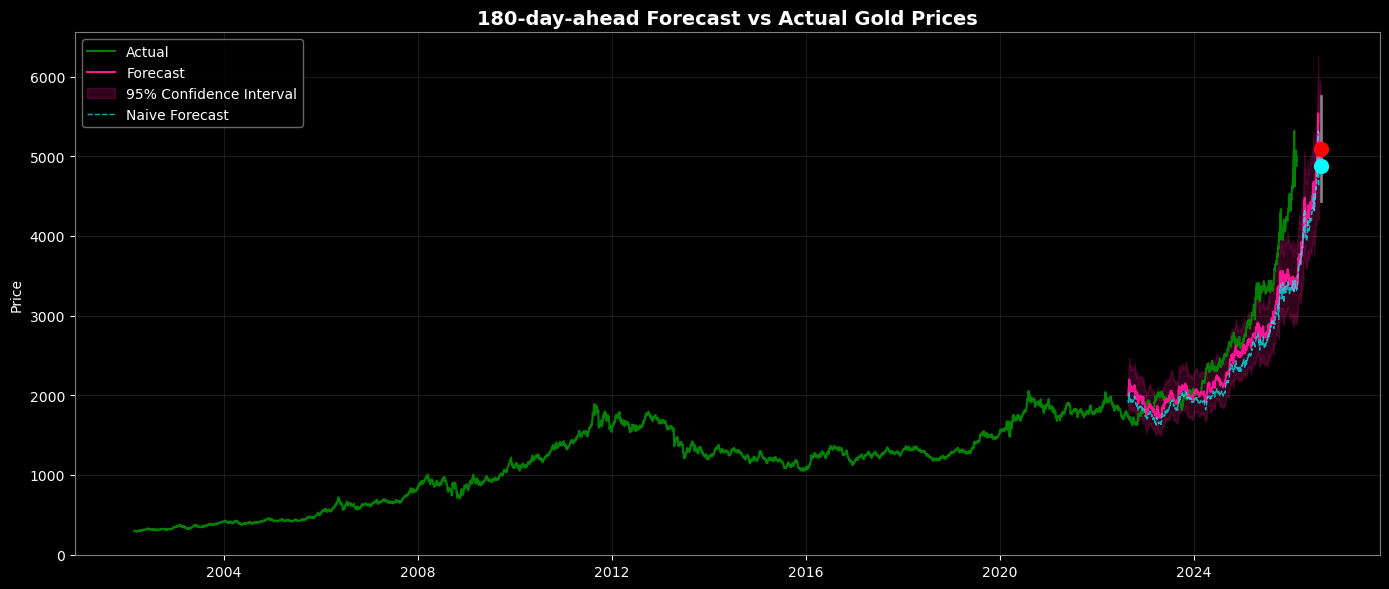

In [117]:
# Plot actual vs predicted price with confidence interval

df_xg['Actual_180_day_Price'] = df_xg['Close'].shift(-180)
pred = reg_180.predict(X_test)

pred_df = pd.DataFrame(
    pred,
    index=X_test.index,
    columns=['Prediction_180']
)

df_xg = df_xg.merge(pred_df, left_index=True, right_index=True, how='left')
df_xg['180_day_Predicted_Price'] = df_xg['Close'] * (1 + df_xg['Prediction_180'])
df_xg['Predicted_Return_Lower'] = df_xg['Prediction_180'] - ci_multiplier * residual_std
df_xg['Predicted_Return_Upper'] = df_xg['Prediction_180'] + ci_multiplier * residual_std
df_xg['Predicted_Price_Lower'] = df_xg['Close'] * (1 + df_xg['Predicted_Return_Lower'])
df_xg['Predicted_Price_Upper'] = df_xg['Close'] * (1 + df_xg['Predicted_Return_Upper'])

# Create matplotlib plot
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('black')

# Plot actual price
ax.plot(df_xg.index, df_xg['Close'], color='green', linewidth=1.5, label='Actual')

# Plot forecasted price (shifted 180 days)
ax.plot(df_xg.index + pd.Timedelta(days=180), df_xg['180_day_Predicted_Price'], 
        color='deeppink', linewidth=1.5, label='Forecast')

# Fill confidence interval
ax.fill_between(df_xg.index + pd.Timedelta(days=180), 
                df_xg['Predicted_Price_Lower'], df_xg['Predicted_Price_Upper'],
                color='deeppink', alpha=0.2, label='95% Confidence Interval')

# ============================

eval_df = df_xg.loc[X_test.index].copy()
eval_df = eval_df.dropna(subset=['180_day_Predicted_Price','Actual_180_day_Price'])
rmse = np.sqrt(mean_squared_error(eval_df['Actual_180_day_Price'],eval_df['180_day_Predicted_Price']))

mask = ~np.isnan(pred) & ~np.isnan(y_test_180)
rmse_return = np.sqrt(mean_squared_error(pred[mask], y_test_180[mask]))
print("Model Return RMSE:", rmse_return)

# ====== Naive Model =====

eval_df['180_day_Naive_Price'] = eval_df['Close']

naive_rmse = np.sqrt(mean_squared_error(
    eval_df['Actual_180_day_Price'],
    eval_df['180_day_Naive_Price']
))

model_rmse = np.sqrt(mean_squared_error(
    eval_df['Actual_180_day_Price'],
    eval_df['180_day_Predicted_Price']
))

print("Naive RMSE:", naive_rmse)
print("Model RMSE:", model_rmse)

df_xg['180_day_Naive_Price'] = np.nan
df_xg.loc[X_test.index, '180_day_Naive_Price'] = df_xg.loc[X_test.index, 'Close']

# Plot naive forecast
ax.plot(df_xg.index + pd.Timedelta(days=180), df_xg['180_day_Naive_Price'],
        color='cyan', linewidth=1, linestyle='--', alpha=0.7, label='Naive Forecast')

ax.legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# directional accuracy

eval_df['actual_return'] = eval_df['Actual_180_day_Price'] / eval_df['Close'] - 1
eval_df['pred_return'] = eval_df['180_day_Predicted_Price'] / eval_df['Close'] - 1
direction_accuracy = ( np.sign(eval_df['actual_return']) == np.sign(eval_df['pred_return'])).mean()
print('Direction_accuracy:', direction_accuracy)

# ===== FUTURE FORECAST =====

latest_X = X.iloc[-1:]
future_return = reg_180.predict(latest_X)[0]
future_return_lower = future_return - ci_multiplier * residual_std
future_return_upper = future_return + ci_multiplier * residual_std
latest_price = df_xg['Close'].iloc[-1]
future_price = latest_price * (1 + future_return)
future_price_lower = latest_price * (1 + future_return_lower)
future_price_upper = latest_price * (1 + future_return_upper)
future_date = df_xg.index[-1] + pd.Timedelta(days=180)

# XGBoost 180-day-ahead model
ax.scatter([future_date], [future_price], color='red', s=100, marker='o', label='XGBoost Forecast', zorder=5)

# confidence interval line
ax.plot([future_date, future_date], [future_price_lower, future_price_upper],
        color='gray', linewidth=2, label='180-day-ahead 95% CI')

# Naive 180-day-ahead model

naive_future_price = latest_price

ax.scatter([future_date], [naive_future_price], color='cyan', s=100, marker='o', label='Naive Forecast', zorder=5)

ax.set_title('180-day-ahead Forecast vs Actual Gold Prices', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Price', color='white')
ax.set_facecolor('black')
ax.grid(True, alpha=0.2, color='gray')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

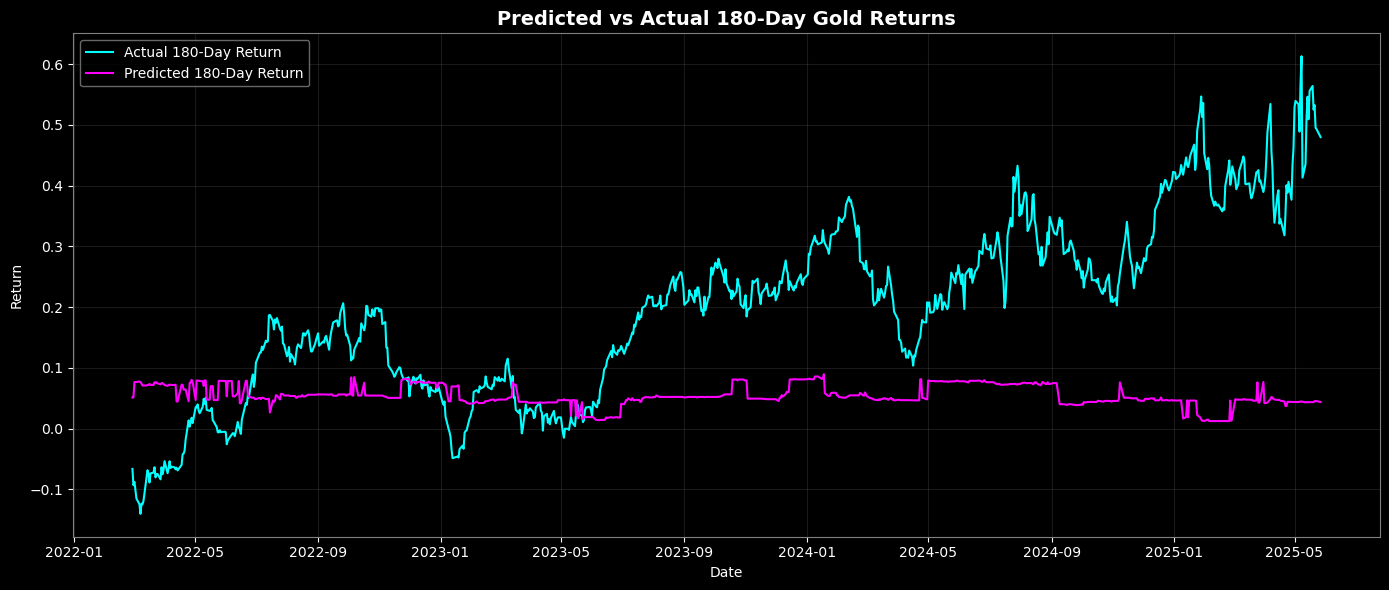

In [118]:
# Create evaluation dataframe for returns
eval_return_df = pd.DataFrame({
    'Actual_Return': y_test_180,
    'Predicted_Return': pred
}, index=X_test.index)

# Drop NaN if any


eval_return_df = eval_return_df.dropna()

fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('black')

# Actual return
ax.plot(eval_return_df.index, eval_return_df['Actual_Return'],
        color='cyan', linewidth=1.5, label='Actual 180-Day Return')

# Predicted return
ax.plot(eval_return_df.index, eval_return_df['Predicted_Return'],
        color='magenta', linewidth=1.5, label='Predicted 180-Day Return')

ax.set_title('Predicted vs Actual 180-Day Gold Returns', color='white', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', color='white')
ax.set_ylabel('Return', color='white')
ax.set_facecolor('black')
ax.grid(True, alpha=0.2, color='gray')
ax.legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

In [119]:
# Train and fit XGBoost 30-day Model

reg_30 = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=100
)

reg_30.fit(
    X_train,
    y_train_30,
    eval_set=[(X_val, y_val_30)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


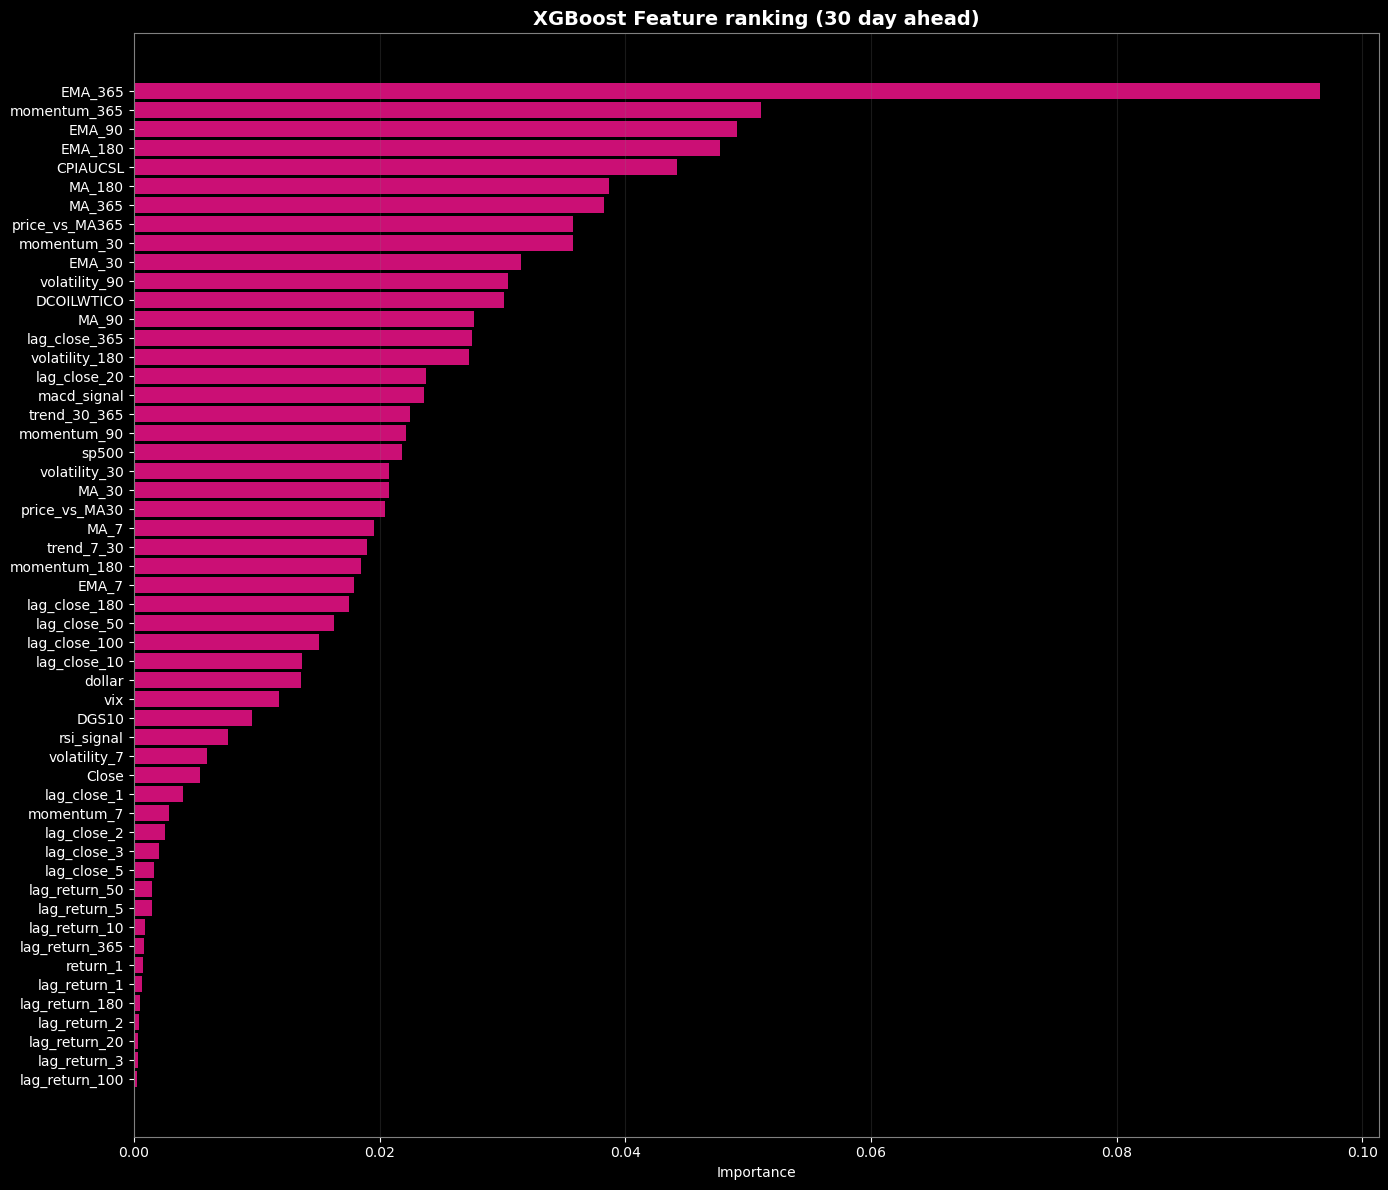

In [120]:
# Ranking feature importance

xg_importance = pd.DataFrame(data = reg_30.feature_importances_, index = reg_30.feature_names_in_, columns = ['Importance']).sort_values(by='Importance', ascending=True)

# Create matplotlib plot
fig, ax = plt.subplots(figsize=(14, 12))
fig.patch.set_facecolor('black')
ax.barh(xg_importance.index, xg_importance['Importance'], color='deeppink', alpha=0.8)
ax.set_title('XGBoost Feature ranking (30 day ahead)', color='white', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance', color='white')
ax.set_facecolor('black')
ax.grid(True, alpha=0.2, color='gray', axis='x')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

In [121]:
# Build confidence interval

val_pred = reg_30.predict(X_val)
residuals = y_val_30 - val_pred
residual_std = residuals.std()
ci_multiplier = 1.96  # 95% confidence interval
print("Residual std:", residual_std)

Residual std: 0.039863413620116556


Model Return RMSE: 0.058050563608957294
Naive RMSE: 187.8945137925878
Model RMSE: 170.21302440682052
Direction_accuracy: 0.6597077244258872


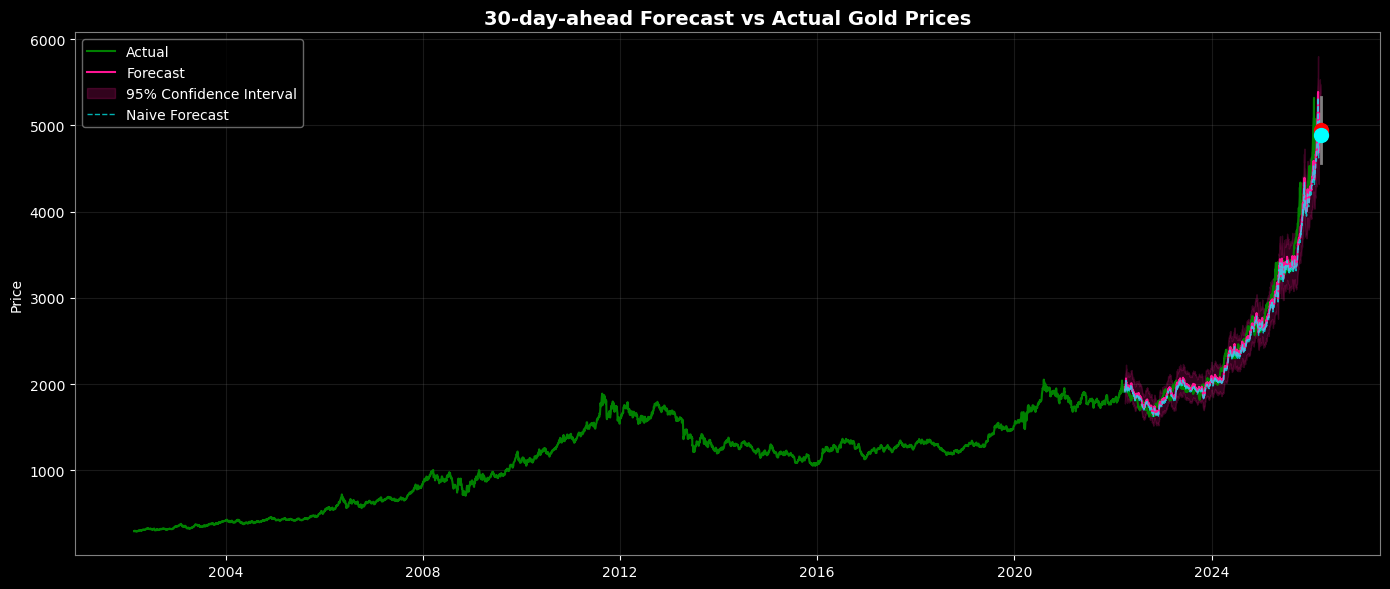

In [122]:
# Plot actual vs predicted price with confidence interval

df_xg['Actual_30_day_Price'] = df_xg['Close'].shift(-30)
pred = reg_30.predict(X_test)

pred_df = pd.DataFrame(
    pred,
    index=X_test.index,
    columns=['Prediction_30']
)

df_xg = df_xg.merge(pred_df, left_index=True, right_index=True, how='left')
df_xg['30_day_Predicted_Price'] = df_xg['Close'] * (1 + df_xg['Prediction_30'])
df_xg['Predicted_Return_Lower'] = df_xg['Prediction_30'] - ci_multiplier * residual_std
df_xg['Predicted_Return_Upper'] = df_xg['Prediction_30'] + ci_multiplier * residual_std
df_xg['Predicted_Price_Lower'] = df_xg['Close'] * (1 + df_xg['Predicted_Return_Lower'])
df_xg['Predicted_Price_Upper'] = df_xg['Close'] * (1 + df_xg['Predicted_Return_Upper'])

# Create matplotlib plot
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('black')

# Plot actual price
ax.plot(df_xg.index, df_xg['Close'], color='green', linewidth=1.5, label='Actual')

# Plot forecasted price (shifted 30 days)
ax.plot(df_xg.index + pd.Timedelta(days=30), df_xg['30_day_Predicted_Price'], 
        color='deeppink', linewidth=1.5, label='Forecast')

# Fill confidence interval
ax.fill_between(df_xg.index + pd.Timedelta(days=30), 
                df_xg['Predicted_Price_Lower'], df_xg['Predicted_Price_Upper'],
                color='deeppink', alpha=0.2, label='95% Confidence Interval')

# ============================

eval_df = df_xg.loc[X_test.index].copy()
eval_df = eval_df.dropna(subset=['30_day_Predicted_Price','Actual_30_day_Price'])
rmse = np.sqrt(mean_squared_error(eval_df['Actual_30_day_Price'],eval_df['30_day_Predicted_Price']))

mask = ~np.isnan(pred) & ~np.isnan(y_test_30)
rmse_return = np.sqrt(mean_squared_error(pred[mask], y_test_30[mask]))
print("Model Return RMSE:", rmse_return)

# ====== Naive Model =====

eval_df['30_day_Naive_Price'] = eval_df['Close']

naive_rmse = np.sqrt(mean_squared_error(
    eval_df['Actual_30_day_Price'],
    eval_df['30_day_Naive_Price']
))

model_rmse = np.sqrt(mean_squared_error(
    eval_df['Actual_30_day_Price'],
    eval_df['30_day_Predicted_Price']
))

print("Naive RMSE:", naive_rmse)
print("Model RMSE:", model_rmse)

df_xg['30_day_Naive_Price'] = np.nan
df_xg.loc[X_test.index, '30_day_Naive_Price'] = df_xg.loc[X_test.index, 'Close']

# Plot naive forecast
ax.plot(df_xg.index + pd.Timedelta(days=30), df_xg['30_day_Naive_Price'],
        color='cyan', linewidth=1, linestyle='--', alpha=0.7, label='Naive Forecast')

ax.legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# directional accuracy

eval_df['actual_return'] = eval_df['Actual_30_day_Price'] / eval_df['Close'] - 1
eval_df['pred_return'] = eval_df['30_day_Predicted_Price'] / eval_df['Close'] - 1
direction_accuracy = ( np.sign(eval_df['actual_return']) == np.sign(eval_df['pred_return'])).mean()
print('Direction_accuracy:', direction_accuracy)

# ===== FUTURE FORECAST =====

latest_X = X.iloc[-1:]
future_return = reg_30.predict(latest_X)[0]
future_return_lower = future_return - ci_multiplier * residual_std
future_return_upper = future_return + ci_multiplier * residual_std
latest_price = df_xg['Close'].iloc[-1]
future_price = latest_price * (1 + future_return)
future_price_lower = latest_price * (1 + future_return_lower)
future_price_upper = latest_price * (1 + future_return_upper)
future_date = df_xg.index[-1] + pd.Timedelta(days=30)

# XGBoost 30-day-ahead model
ax.scatter([future_date], [future_price], color='red', s=100, marker='o', label='XGBoost Forecast', zorder=5)

# confidence interval line
ax.plot([future_date, future_date], [future_price_lower, future_price_upper],
        color='gray', linewidth=2, label='30-day-ahead 95% CI')

# Naive 30-day-ahead model

naive_future_price = latest_price

ax.scatter([future_date], [naive_future_price], color='cyan', s=100, marker='o', label='Naive Forecast', zorder=5)

ax.set_title('30-day-ahead Forecast vs Actual Gold Prices', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Price', color='white')
ax.set_facecolor('black')
ax.grid(True, alpha=0.2, color='gray')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

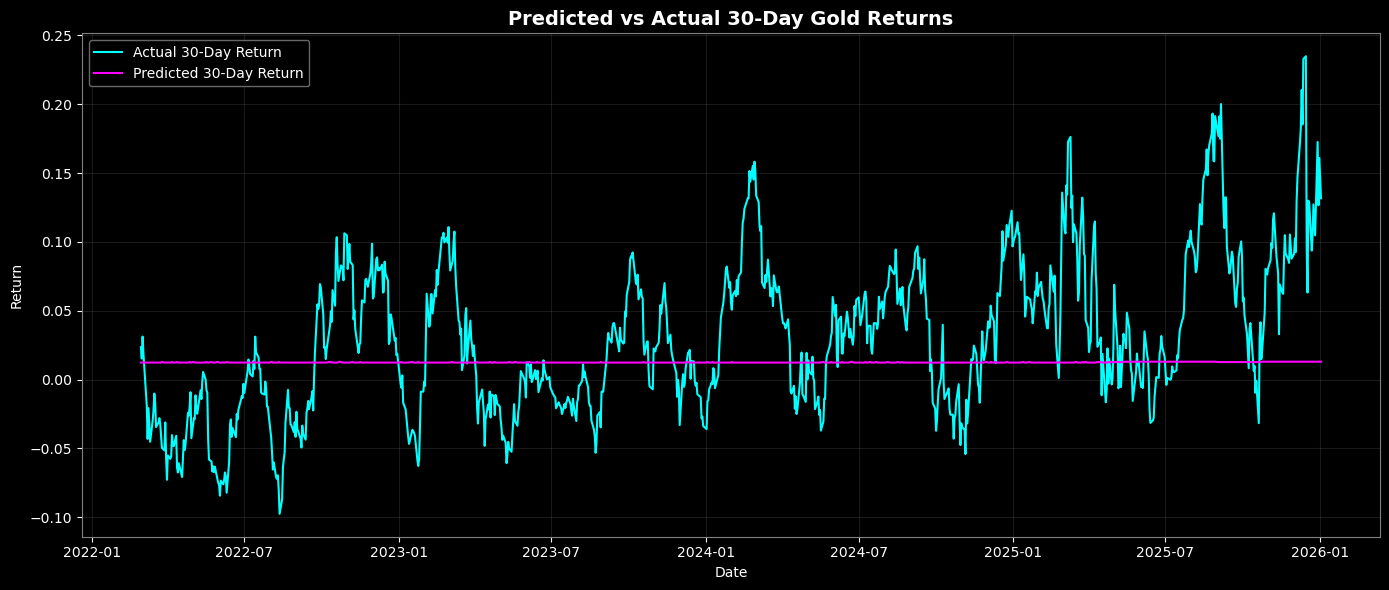

In [123]:
# Create evaluation dataframe for returns
eval_return_df = pd.DataFrame({
    'Actual_Return': y_test_30,
    'Predicted_Return': pred
}, index=X_test.index)

eval_return_df = eval_return_df.dropna()

fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('black')

# Actual return
ax.plot(eval_return_df.index, eval_return_df['Actual_Return'],
        color='cyan', linewidth=1.5, label='Actual 30-Day Return')

# Predicted return
ax.plot(eval_return_df.index, eval_return_df['Predicted_Return'],
        color='magenta', linewidth=1.5, label='Predicted 30-Day Return')

ax.set_title('Predicted vs Actual 30-Day Gold Returns', color='white', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', color='white')
ax.set_ylabel('Return', color='white')
ax.set_facecolor('black')
ax.grid(True, alpha=0.2, color='gray')
ax.legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

In [124]:
# Train and fit XGBoost 1-day Model

reg_1 = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=100
)

reg_1.fit(
    X_train,
    y_train_1,
    eval_set=[(X_val, y_val_1)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


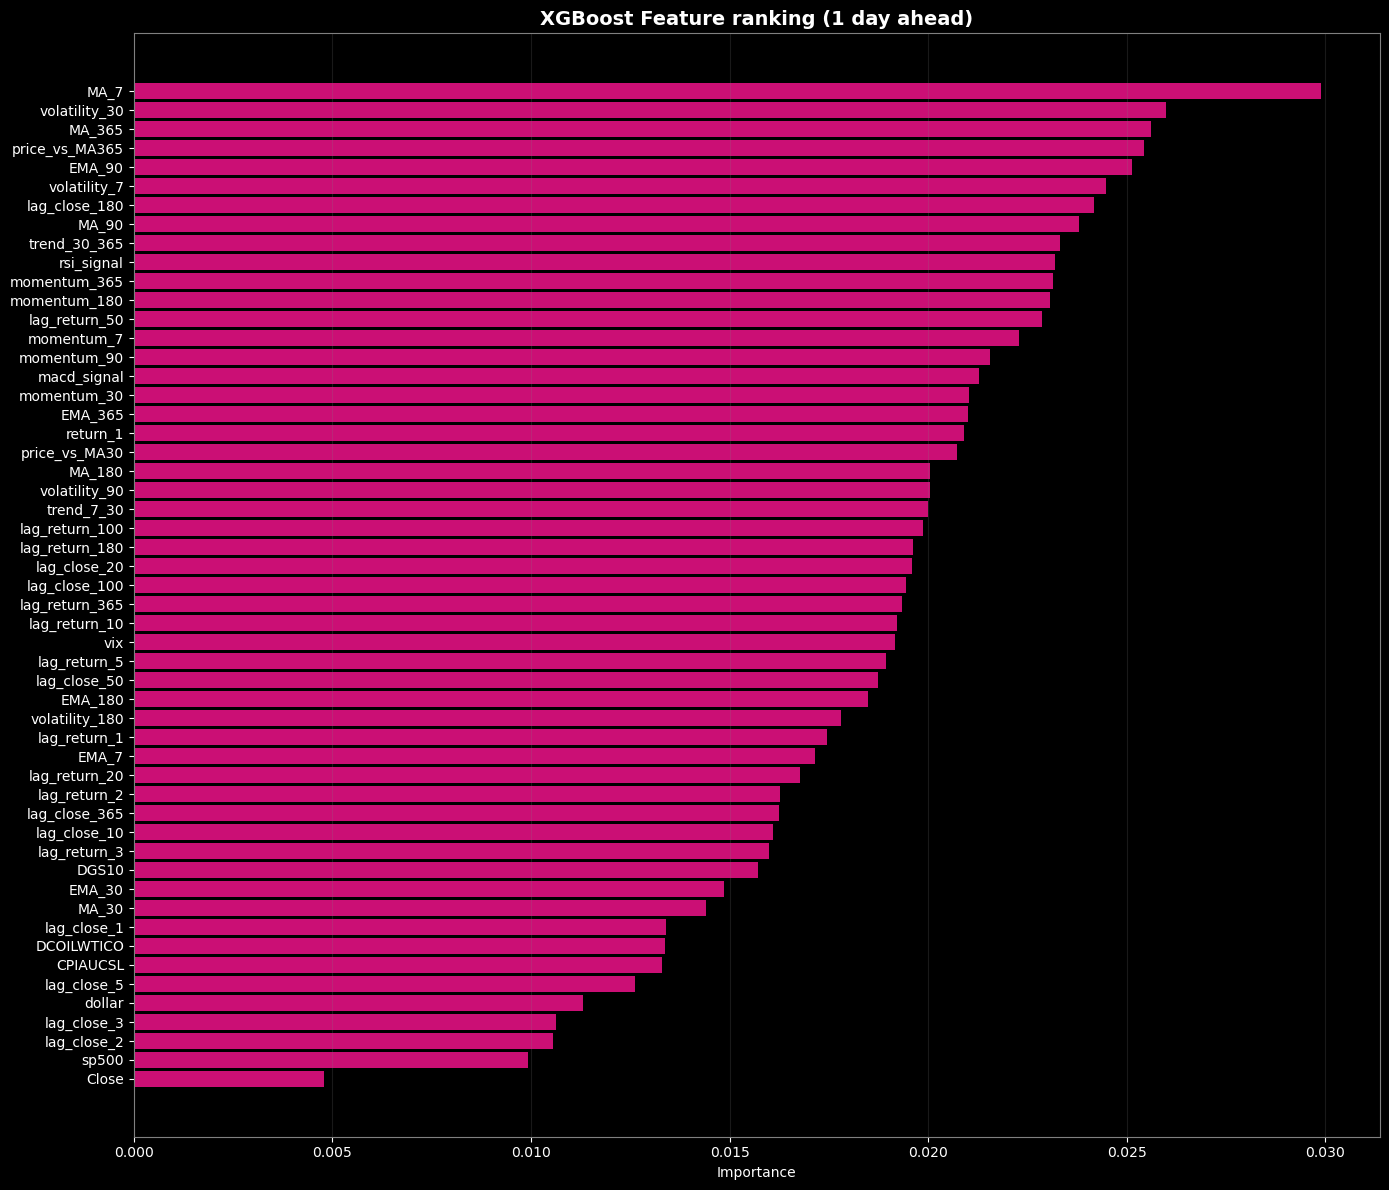

In [125]:
# Ranking feature importance

xg_importance = pd.DataFrame(data = reg_1.feature_importances_, index = reg_1.feature_names_in_, columns = ['Importance']).sort_values(by='Importance', ascending=True)

# Create matplotlib plot
fig, ax = plt.subplots(figsize=(14, 12))
fig.patch.set_facecolor('black')
ax.barh(xg_importance.index, xg_importance['Importance'], color='deeppink', alpha=0.8)
ax.set_title('XGBoost Feature ranking (1 day ahead)', color='white', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance', color='white')
ax.set_facecolor('black')
ax.grid(True, alpha=0.2, color='gray', axis='x')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

In [126]:
# Build confidence interval

val_pred = reg_1.predict(X_val)
residuals = y_val_1 - val_pred
residual_std = residuals.std()
ci_multiplier = 1.96  # 95% confidence interval
print("Residual std:", residual_std)

Residual std: 0.009033609483394793


Model Return RMSE: 0.011517240391627142
Naive RMSE: 39.17619273532972
Model RMSE: 39.10411389031321
Direction_accuracy: 0.4387031408308004


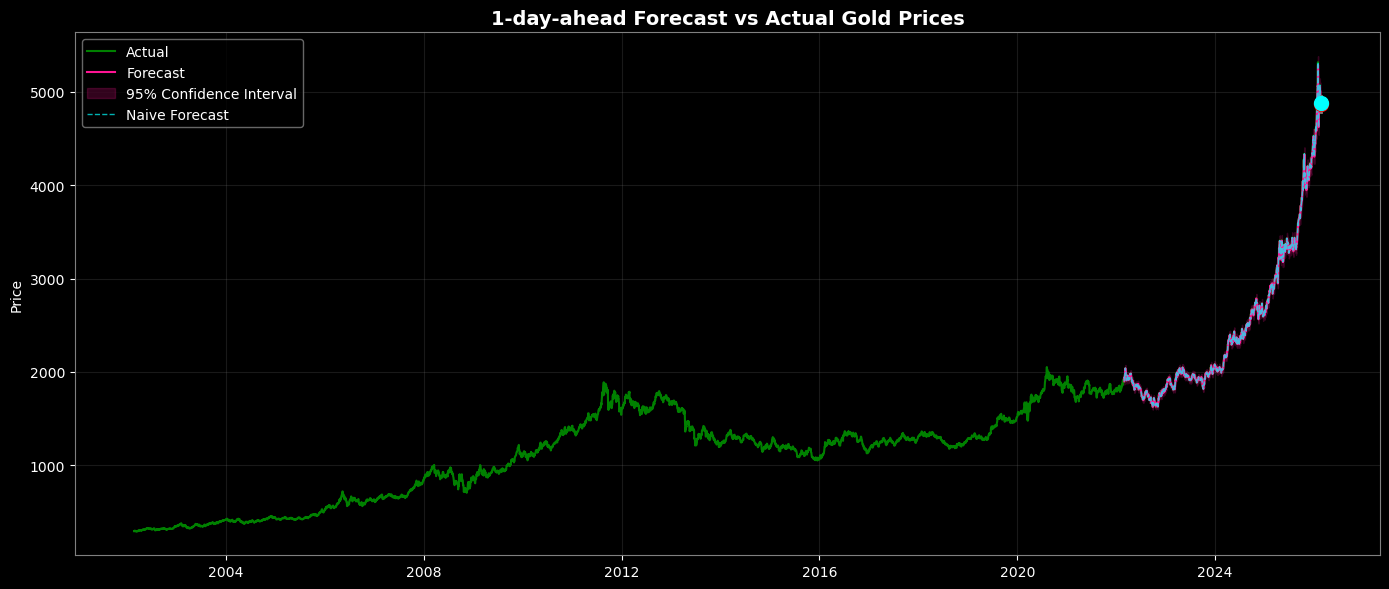

In [127]:
# Plot actual vs predicted price with confidence interval

df_xg['Actual_1_day_Price'] = df_xg['Close'].shift(-1)
pred = reg_1.predict(X_test)

pred_df = pd.DataFrame(
    pred,
    index=X_test.index,
    columns=['Prediction_1']
)

df_xg = df_xg.merge(pred_df, left_index=True, right_index=True, how='left')
df_xg['1_day_Predicted_Price'] = df_xg['Close'] * (1 + df_xg['Prediction_1'])
df_xg['Predicted_Return_Lower'] = df_xg['Prediction_1'] - ci_multiplier * residual_std
df_xg['Predicted_Return_Upper'] = df_xg['Prediction_1'] + ci_multiplier * residual_std
df_xg['Predicted_Price_Lower'] = df_xg['Close'] * (1 + df_xg['Predicted_Return_Lower'])
df_xg['Predicted_Price_Upper'] = df_xg['Close'] * (1 + df_xg['Predicted_Return_Upper'])

# Create matplotlib plot
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('black')

# Plot actual price
ax.plot(df_xg.index, df_xg['Close'], color='green', linewidth=1.5, label='Actual')

# Plot forecasted price (shifted 1 days)
ax.plot(df_xg.index + pd.Timedelta(days=1), df_xg['1_day_Predicted_Price'], 
        color='deeppink', linewidth=1.5, label='Forecast')

# Fill confidence interval
ax.fill_between(df_xg.index + pd.Timedelta(days=1), 
                df_xg['Predicted_Price_Lower'], df_xg['Predicted_Price_Upper'],
                color='deeppink', alpha=0.2, label='95% Confidence Interval')

# ============================

eval_df = df_xg.loc[X_test.index].copy()
eval_df = eval_df.dropna(subset=['1_day_Predicted_Price','Actual_1_day_Price'])
rmse = np.sqrt(mean_squared_error(eval_df['Actual_1_day_Price'],eval_df['1_day_Predicted_Price']))

mask = ~np.isnan(pred) & ~np.isnan(y_test_1)
rmse_return = np.sqrt(mean_squared_error(pred[mask], y_test_1[mask]))
print("Model Return RMSE:", rmse_return)

# ====== Naive Model =====

eval_df['1_day_Naive_Price'] = eval_df['Close']

naive_rmse = np.sqrt(mean_squared_error(
    eval_df['Actual_1_day_Price'],
    eval_df['1_day_Naive_Price']
))

model_rmse = np.sqrt(mean_squared_error(
    eval_df['Actual_1_day_Price'],
    eval_df['1_day_Predicted_Price']
))

print("Naive RMSE:", naive_rmse)
print("Model RMSE:", model_rmse)

df_xg['1_day_Naive_Price'] = np.nan
df_xg.loc[X_test.index, '1_day_Naive_Price'] = df_xg.loc[X_test.index, 'Close']

# Plot naive forecast
ax.plot(df_xg.index + pd.Timedelta(days=1), df_xg['1_day_Naive_Price'],
        color='cyan', linewidth=1, linestyle='--', alpha=0.7, label='Naive Forecast')

ax.legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')

# directional accuracy

eval_df['actual_return'] = eval_df['Actual_1_day_Price'] / eval_df['Close'] - 1
eval_df['pred_return'] = eval_df['1_day_Predicted_Price'] / eval_df['Close'] - 1
direction_accuracy = ( np.sign(eval_df['actual_return']) == np.sign(eval_df['pred_return'])).mean()
print('Direction_accuracy:', direction_accuracy)

# ===== FUTURE FORECAST =====

latest_X = X.iloc[-1:]
future_return = reg_1.predict(latest_X)[0]
future_return_lower = future_return - ci_multiplier * residual_std
future_return_upper = future_return + ci_multiplier * residual_std
latest_price = df_xg['Close'].iloc[-1]
future_price = latest_price * (1 + future_return)
future_price_lower = latest_price * (1 + future_return_lower)
future_price_upper = latest_price * (1 + future_return_upper)
future_date = df_xg.index[-1] + pd.Timedelta(days=1)

# XGBoost 1-day-ahead model
ax.scatter([future_date], [future_price], color='red', s=100, marker='o', label='XGBoost Forecast', zorder=5)

# confidence interval line
ax.plot([future_date, future_date], [future_price_lower, future_price_upper],
        color='gray', linewidth=2, label='1-day-ahead 95% CI')

# Naive 1-day-ahead model

naive_future_price = latest_price

ax.scatter([future_date], [naive_future_price], color='cyan', s=100, marker='o', label='Naive Forecast', zorder=5)

ax.set_title('1-day-ahead Forecast vs Actual Gold Prices', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Price', color='white')
ax.set_facecolor('black')
ax.grid(True, alpha=0.2, color='gray')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

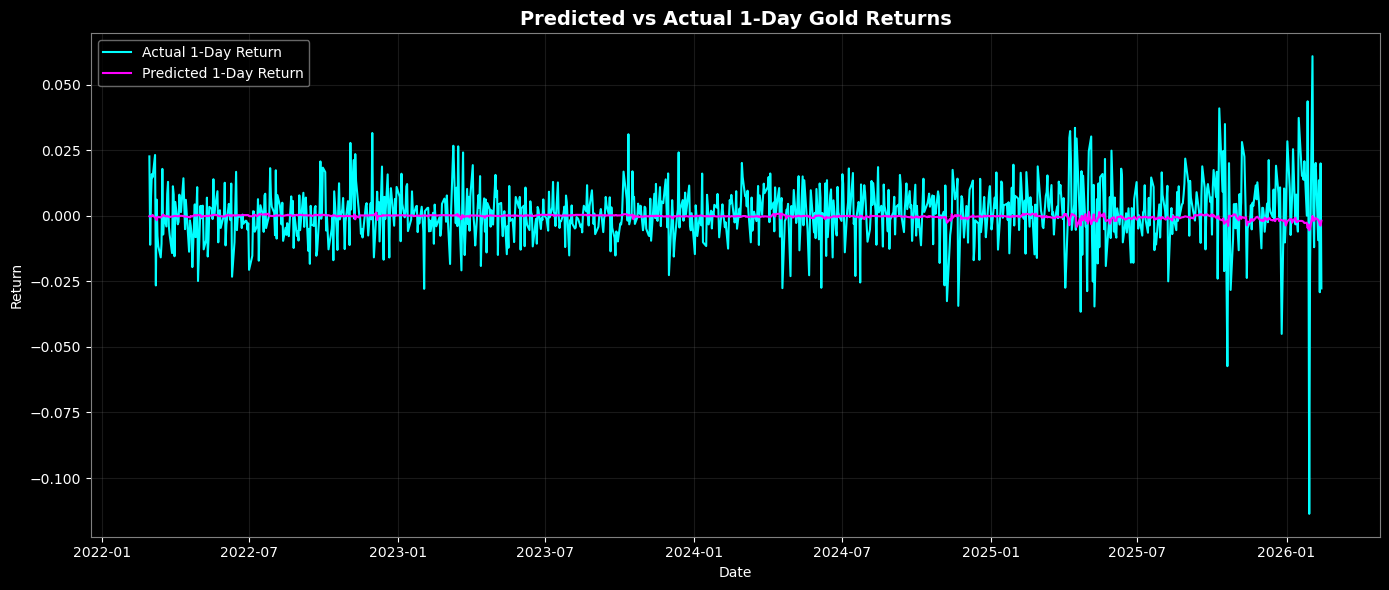

In [128]:
# Create evaluation dataframe for returns
eval_return_df = pd.DataFrame({
    'Actual_Return': y_test_1,
    'Predicted_Return': pred
}, index=X_test.index)

eval_return_df = eval_return_df.dropna()

fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('black')

# Actual return
ax.plot(eval_return_df.index, eval_return_df['Actual_Return'],
        color='cyan', linewidth=1.5, label='Actual 1-Day Return')

# Predicted return
ax.plot(eval_return_df.index, eval_return_df['Predicted_Return'],
        color='magenta', linewidth=1.5, label='Predicted 1-Day Return')

ax.set_title('Predicted vs Actual 1-Day Gold Returns', color='white', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', color='white')
ax.set_ylabel('Return', color='white')
ax.set_facecolor('black')
ax.grid(True, alpha=0.2, color='gray')
ax.legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

### FB Prophet

In [129]:
prophet_df = gold.copy().reset_index()
prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'})

In [130]:
# Split data
test_prophet = prophet_df.iloc[-1000:]
train_prophet = prophet_df.iloc[:-1000]
print(test_prophet.iloc[0]['ds'])

2022-02-28 00:00:00


In [131]:
fbp = Prophet(yearly_seasonality = True, daily_seasonality = False,)
fbp.fit(train_prophet)
future = fbp.make_future_dataframe(periods = 2000)
forecast = fbp.predict(future)

15:51:06 - cmdstanpy - INFO - Chain [1] start processing
15:51:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model RMSE: 684.4322448996818


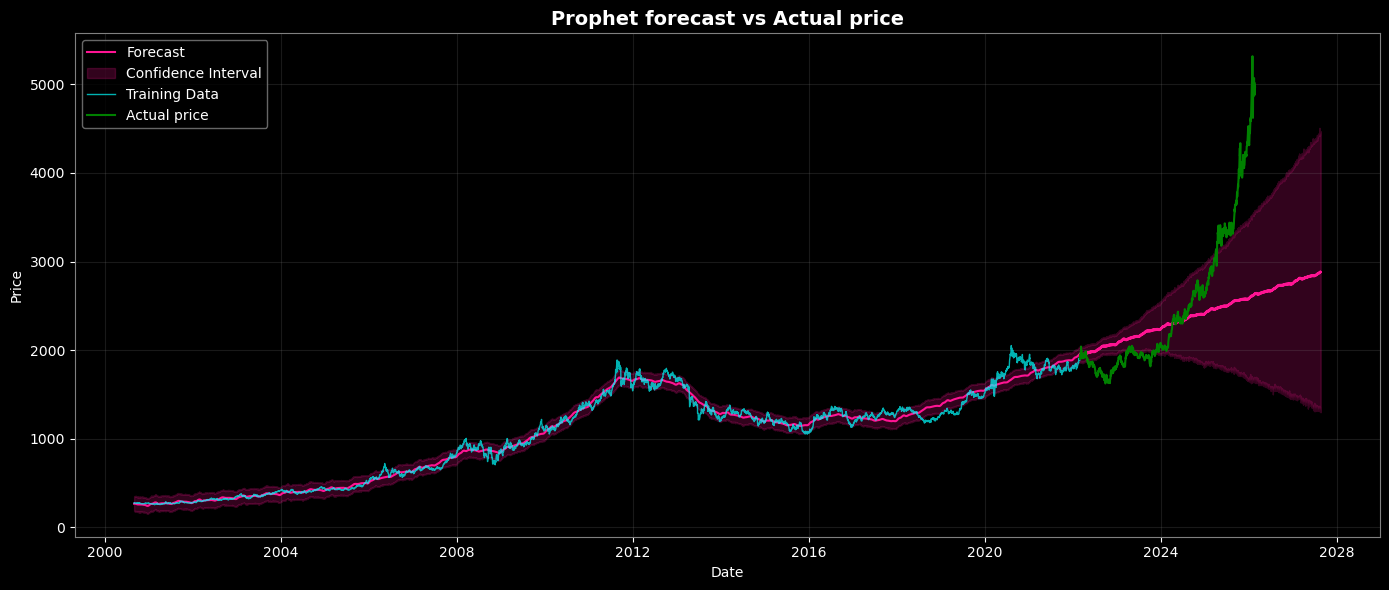

In [132]:
# Plot Prophet model

# Use matplotlib instead of plotly
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Make forecast
future = fbp.make_future_dataframe(periods=2000)
forecast = fbp.predict(future)

# Plot forecast
ax.plot(forecast['ds'], forecast['yhat'], color='deeppink', linewidth=1.5, label='Forecast')

# Plot confidence interval
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color='deeppink', alpha=0.2, label='Confidence Interval')

# Plot training data
ax.plot(train_prophet['ds'], train_prophet['y'], color='cyan', linewidth=1, alpha=0.7, label='Training Data')

# Plot test data
ax.plot(test_prophet['ds'], test_prophet['y'], color='green', linewidth=1.5, label='Actual price')

ax.set_title('Prophet forecast vs Actual price', color='white', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', color='white')
ax.set_ylabel('Price', color='white')
ax.grid(True, alpha=0.2, color='gray')
ax.legend(loc='upper left', facecolor='black', edgecolor='gray', labelcolor='white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('gray')
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')

# Evaluate prophet performace
eval_df = test_prophet.merge(forecast, how = 'left', on = 'ds')
mask =  ~np.isnan(eval_df['y']) & ~np.isnan(eval_df['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(eval_df['y'][mask], eval_df['yhat'][mask]))
print('Prophet Model RMSE:', prophet_rmse)

plt.tight_layout()
plt.show()